In [201]:
import pandas as pd
import numpy as np
import urllib2
import urllib
import datetime
import datetime as dt
from datetime import datetime
from pytz import timezone
import pytz
from time import gmtime, strftime
import time
import os
from random import randint
import math
import seaborn
from matplotlib import interactive
interactive(False)
from pylab import rcParams
from pandas_datareader import data as web
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [203]:
def google_finance_datareader(symbol, interval_seconds, num_days):
    url_string = "http://www.google.com/finance/getprices?q={symbol}".format(symbol=symbol.upper())
    url_string += "&i={interval_seconds}&p={num_days}d&f=d,o,h,l,c,v".format(interval_seconds=interval_seconds, num_days=num_days)
    #print(url_string)
    page = urllib.urlopen(url_string)
    df = pd.read_csv(page, skiprows=7, sep=',', names=['DATE', 'CLOSE', 'HIGH', 'LOW', 'OPEN', 'VOLUME'])
    b_dateround = df['DATE'].map(lambda dt: dt[0]=='a')
    dateround = df[b_dateround]['DATE'].map(lambda dt: int(dt[1:]))
    df['DATE2'] = dateround
    df['DATE2'] = df['DATE2'].fillna(method='ffill')
    df['DATE3'] = df[~b_dateround]['DATE'].astype(int)*interval_seconds
    df['DATE3'] = df['DATE3'].fillna(0)
    df['DATE4'] = df['DATE2'] + df['DATE3']
    df['DATE4'] = df['DATE4'].map(lambda s: dt.datetime.fromtimestamp(int(s), pytz.UTC))
    del df['DATE']
    del df['DATE2']
    del df['DATE3']
    df = df.set_index('DATE4', verify_integrity=True)
    df.index.name = 'DATE'
    return(df)

In [204]:
symbol = 'spy'
interval_seconds = 60
num_days = 30
df = google_finance_datareader(symbol, interval_seconds, num_days)

In [205]:
from numba import jit
@jit
def vwap():
    return np.cumsum(df.VOLUME*(df.HIGH+df.LOW)/2) / np.cumsum(df.VOLUME)

In [206]:
%timeit df['vwap'] = vwap()

<ipython-input-205-b05e2d3e6aca>:2: NumbaWarning: Function "vwap" failed type inference: 'DataFrame' objects are mutable, thus they cannot be hashed
  @jit


The slowest run took 934.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 556 µs per loop


<ipython-input-205-b05e2d3e6aca>:2: NumbaWarning: Function "vwap" was compiled in object mode without forceobj=True.
  @jit


STRATEGY: price < vwap * 0.995 -> sell and price > vwap * 1.005-> buy. or 0.999 and 1.001

STRATEGY:vwap_15>vwap_30 -> buy 

In [207]:
df['VWAP15'] =pd.rolling_sum(df['CLOSE'] * df['VOLUME'], window = 15)/pd.rolling_sum(df['VOLUME'], window = 15)

In [208]:
df['VWAP30'] =pd.rolling_sum(df['CLOSE'] * df['VOLUME'], window = 30)/pd.rolling_sum(df['VOLUME'], window = 30)

In [209]:
df.tail()

,CLOSE,HIGH,LOW,OPEN,VOLUME,vwap,VWAP15,VWAP30
DATE,,,,,,,,
2016-08-30 19:56:00+00:00,217.890,217.900,217.86,217.86,103028,218.210007,217.890457,217.849193
2016-08-30 19:57:00+00:00,217.875,217.895,217.82,217.89,128413,218.209842,217.884005,217.853537
2016-08-30 19:58:00+00:00,217.820,217.870,217.81,217.87,216812,218.209550,217.867242,217.849923
2016-08-30 19:59:00+00:00,217.870,217.880,217.82,217.83,84935,218.209438,217.866218,217.853549
2016-08-30 20:00:00+00:00,217.980,217.980,217.87,217.87,1084317,218.208318,217.927199,217.905557


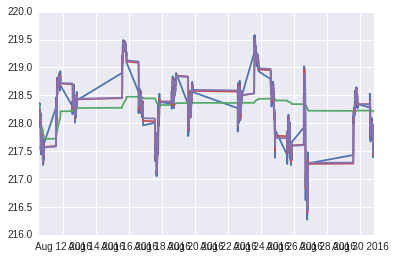

In [210]:
plt.plot(df.CLOSE)
plt.plot(df.vwap)
plt.plot(df.VWAP15)
plt.plot(df.VWAP30)

In [211]:
#stationary test of OPEN price
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df.OPEN, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Test Statistic                   -3.309206
p-value                           0.014472
#Lags Used                       11.000000
Number of Observations Used    5850.000000
Critical Value (5%)              -2.862034
Critical Value (1%)              -3.431468
Critical Value (10%)             -2.567033
dtype: float64


Estimating & Eliminating Trend

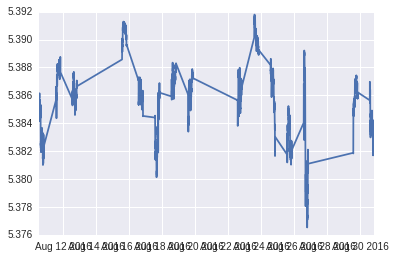

In [212]:
ts_log = np.log(df.OPEN)
plt.plot(ts_log)
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
ret=ts_log_diff.dropna()

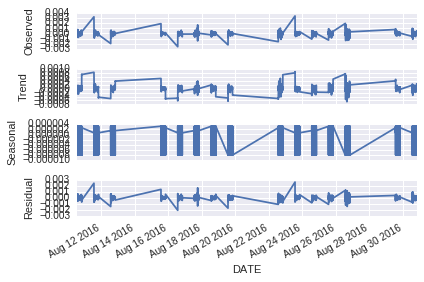

In [213]:
#from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm 
res = sm.tsa.seasonal_decompose(ret,freq=5,model='additive')
resplot = res.plot()
#resplot.savefig('Seasonal_Decompose.png', dpi=150)

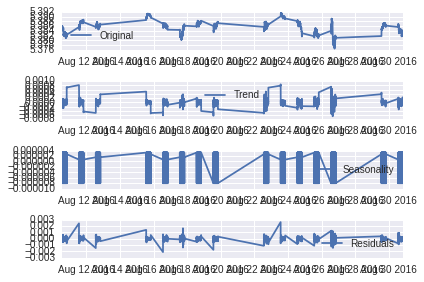

In [214]:
decomposition = res

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [215]:
ts_log_decompose = residual
ts_log_decompose=ts_log_decompose.dropna()

In [216]:
dftest = adfuller(ts_log_decompose, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Test Statistic                  -27.494986
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    5822.000000
Critical Value (5%)              -2.862037
Critical Value (1%)              -3.431474
Critical Value (10%)             -2.567034
dtype: float64


Forecasting a Time Series

In [217]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ret, nlags=20)
lag_pacf = pacf(ret, nlags=20, method='ols')

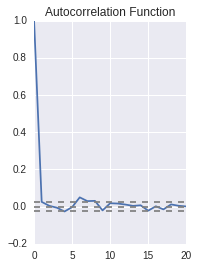

In [218]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

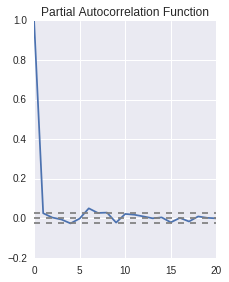

In [219]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [220]:
from statsmodels.tsa.arima_model import ARIMA

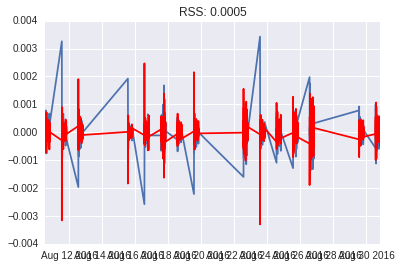

In [221]:
model = ARIMA(ret, order=(11,1,11))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ret)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ret)**2))

Taking it back to original scale

In [225]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

DATE
2016-08-10 13:32:00+00:00    6.203417e-09
2016-08-10 13:33:00+00:00    2.223753e-05
2016-08-10 13:34:00+00:00    1.942133e-04
2016-08-10 13:35:00+00:00   -5.485569e-05
2016-08-10 13:36:00+00:00    3.054154e-04
dtype: float64


In [226]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

DATE
2016-08-10 13:32:00+00:00    6.203417e-09
2016-08-10 13:33:00+00:00    2.224373e-05
2016-08-10 13:34:00+00:00    2.164570e-04
2016-08-10 13:35:00+00:00    1.616013e-04
2016-08-10 13:36:00+00:00    4.670167e-04
dtype: float64


In [227]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

DATE
2016-08-10 13:30:00+00:00    5.385824
2016-08-10 13:31:00+00:00    5.385824
2016-08-10 13:32:00+00:00    5.385824
2016-08-10 13:33:00+00:00    5.385847
2016-08-10 13:34:00+00:00    5.386041
dtype: float64

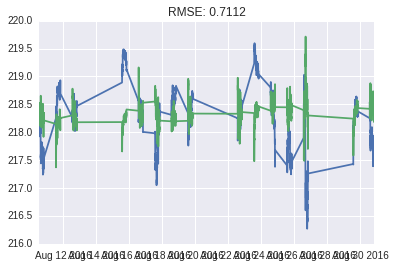

In [228]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df.OPEN)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df.OPEN)**2)/len(df.OPEN)))

In [229]:
df['ARIMA']=predictions_ARIMA
df=df.dropna()

GARCH

In [231]:
#Defining the t-test function to be used later
def print_ttest(x,mu=0,ci=95):
    #performs one sample t-test to check if population mean
    from scipy import stats
    print "one sample t test"
    t,prob = stats.ttest_1samp(x,popmean=mu)
    
    values = {90:1.645,95:1.960,98:2.326,99:2.576}
    
    print "t = ",t, "p value = ",prob
    print "alternative hypothesis: true mean is not equal to 0"
    print "95% confidence interval"
    cl = np.mean(x) - values[ci] * np.std(x)/np.sqrt(len(x))
    cu = np.mean(x) + values[ci] * np.std(x)/np.sqrt(len(x))
    
    print(cl,cu)
    
    print "sample estimate \nmean of data"
    print(np.mean(x))

In [232]:
from statsmodels.stats.diagnostic import acorr_ljungbox
#testing for ARCH effects in intc data
print_ttest(ts_log) #test to see if the mean of the returns is 0


one sample t test
t =  149317.198429 p value =  0.0
alternative hypothesis: true mean is not equal to 0
95% confidence interval
(5.3857960851063211, 5.3859374673255598)
sample estimate 
mean of data
5.38586677622


In [235]:
acorr_ljungbox(ret**2,lags=12)

(array([ 17.70990312,  43.58292434,  47.83100117,  51.47038272,
         53.10137035,  54.88448868,  58.42403133,  61.48554874,
         63.30311831,  65.08037603,  73.34823472,  78.17906415]),
 array([  2.57283670e-05,   3.43627749e-10,   2.31331959e-10,
          1.78004794e-10,   3.20596224e-10,   4.89123992e-10,
          3.11283925e-10,   2.38058851e-10,   3.08145493e-10,
          3.91229403e-10,   2.80856248e-11,   9.17151592e-12]))

In [236]:
from statsmodels.stats.diagnostic import het_arch
het_arch(ret,maxlag=12)[2:]

(5.2122907587309051, 8.6854884914821936e-09)

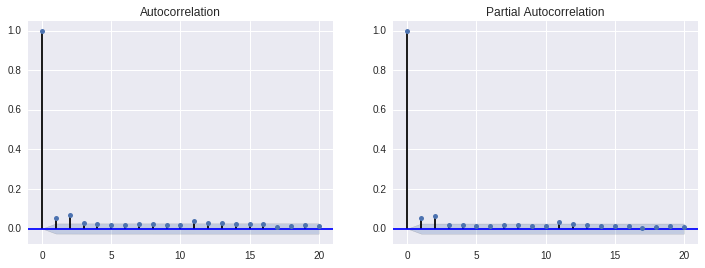

In [238]:
import statsmodels.graphics.tsaplots as tsaplots
rcParams['figure.figsize']=12,4
fig,ax = plt.subplots(1,2)
tsaplots.plot_acf(ret**2,lags=20,ax=ax[0]);
tsaplots.plot_pacf(ret**2,lags=20,ax=ax[1]);

In [308]:
#model determination (intel corporation)
#looking at the PACF graph, we will choose a ARCH(3) model. Hence:
from arch import arch_model
m1 = arch_model(ret,vol='ARCH',mean='Constant',p=17,q=13).fit()
print(m1.summary())

Iteration:      1,   Func. Count:     21,   Neg. LLF: -41663.6840674
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -41663.6840672
            Iterations: 1
            Function evaluations: 21
            Gradient evaluations: 1


/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   OPEN   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                41663.7
Distribution:                  Normal   AIC:                          -83289.4
Method:            Maximum Likelihood   BIC:                          -83162.5
                                        No. Observations:                 5861
Date:                Fri, Sep 02 2016   Df Residuals:                     5842
Time:                        15:37:01   Df Model:                           19
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -3.2860e-07  2.565e-07     -1.281     

In [242]:
#same as above.  But here, we separate out model and do it in components.  The anssers from the fit are the same as abve
from arch.univariate import ConstantMean
ar = ConstantMean(ret) # Hence we have the model r_t = mu + a_t
from arch.univariate import ARCH
ar.volatility = ARCH(p=5) #var = alpha_0 + alpha_1 a_{t-1}^2 + alpha_2 a_{t-2}^2 + alpha_3 a_{t-3}^3
print(ar.fit().summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: -41684.4710009
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -41684.4709965
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   OPEN   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                41684.5
Distribution:                  Normal   AIC:                          -83354.9
Method:            Maximum Likelihood   BIC:                          -83308.2
                                        No. Observations:                 5861
Date:                Wed, Aug 31 2016   Df Residuals:                     5854
Time:                        10:44:24   Df Model:                            7
                  

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [243]:
import arch

In [244]:
am = arch.arch_model(ret)
res = am.fit(5)
res.params

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -41746.4336229
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1


/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


mu         -3.285957e-07
omega       4.528683e-09
alpha[1]    2.000000e-01
beta[1]     7.000000e-01
Name: params, dtype: float64

In [285]:
df['stdev']=pd.rolling_std(df.OPEN.pct_change().dropna(),21)
df['GARCH']=np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])
df=df.dropna()

In [276]:
# Function to compute parameters
def sharpe_ratio(x):
    mu, sigma = x.mean(), np.sqrt(x.var())
    return np.array([mu, sigma, mu / sigma])

# Bootstrap confidence intervals
from arch.bootstrap import IIDBootstrap
bs = IIDBootstrap(ret)
ci = bs.conf_int(sharpe_ratio, 1000, method='percentile')

array([[ -6.00448474e-06,   1.95642288e-04,  -2.89287775e-02],
       [  5.43377131e-06,   2.29248497e-04,   2.51780535e-02]])

In [298]:
df['bs']=ci[0][1]

In [299]:
df.head(15)

,CLOSE,HIGH,LOW,OPEN,VOLUME,vwap,VWAP15,VWAP30,ARIMA,stdev,GARCH,bs
DATE,,,,,,,,,,,,
2016-08-10 14:41:00+00:00,217.980,218.02,217.950,218.020,35889,218.145129,218.103070,218.101959,218.221902,0.000284,0.000267,0.000196
2016-08-10 14:42:00+00:00,218.010,218.01,217.960,217.980,14347,218.144534,218.097328,218.102218,218.303762,0.000287,0.000247,0.000196
2016-08-10 14:43:00+00:00,217.970,218.02,217.955,218.020,28971,218.143364,218.088693,218.100622,218.342944,0.000228,0.000232,0.000196
2016-08-10 14:44:00+00:00,218.000,218.03,217.960,217.970,45240,218.141657,218.079802,218.096826,218.307035,0.000231,0.000230,0.000196
2016-08-10 14:45:00+00:00,218.090,218.09,217.990,218.000,25401,218.141005,218.080777,218.098022,218.351946,0.000231,0.000213,0.000196
2016-08-10 14:46:00+00:00,218.040,218.09,218.000,218.090,38796,218.140073,218.073940,218.097734,218.321311,0.000250,0.000265,0.000196
2016-08-10 14:47:00+00:00,218.030,218.06,218.020,218.045,25348,218.139443,218.064797,218.096488,218.221497,0.000253,0.000250,0.000196
2016-08-10 14:48:00+00:00,218.070,218.08,218.040,218.040,31141,218.138833,218.060910,218.096834,218.263086,0.000251,0.000220,0.000196
2016-08-10 14:49:00+00:00,218.120,218.14,218.075,218.080,42182,218.138510,218.065284,218.099486,218.270734,0.000255,0.000212,0.000196


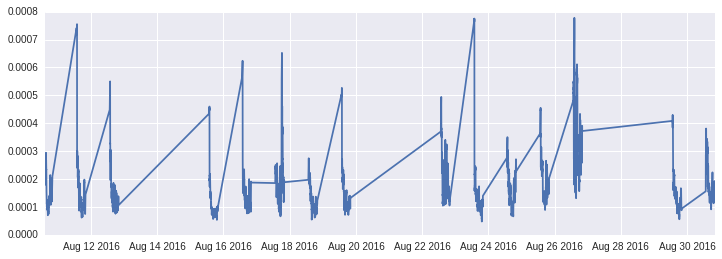

In [288]:
plt.plot(df.stdev)

https://www.quantopian.com/posts/quantopian-lecture-series-arch-garch-and-gmm

Simulating a GARCH(1, 1) Case

In [311]:
import cvxopt
from functools import partial
import math
import numpy as np
import scipy
from scipy import stats
import statsmodels as sm
from statsmodels.stats.stattools import jarque_bera

import matplotlib.pyplot as plt

In [333]:
# Define parameters
a0 = 1.0
a1 = 0.2
b1 = 0.7
sigma1 = math.sqrt(a0 / (1 - a1 - b1))

In [361]:
len(ret)

5861

In [313]:
def simulate_GARCH(T, a0, a1, b1, sigma1):
    
    # Initialize our values
    X = np.ndarray(T)
    sigma = np.ndarray(T)
    sigma[0] = sigma1
    
    for t in range(1, T):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(a0 + b1 * sigma[t - 1]**2 + a1 * X[t - 1]**2)
        
    X[T - 1] = sigma[T - 1] * np.random.normal(0, 1)    
    
    return X, sigma

In [345]:
X, _ = simulate_GARCH(6861, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in
X = X / np.std(X) # Normalize X

In [346]:
len(X)

5861

In [347]:
def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))
    for k in range(4):
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Compare to Gaussian distribution
    return A

compare_tails_to_normal(X)

array([[  1.26940795e-01,   2.23511346e-02,   4.94796110e-03,
          1.02371609e-03],
       [  1.58655254e-01,   2.27501319e-02,   1.34989803e-03,
          3.16712418e-05]])

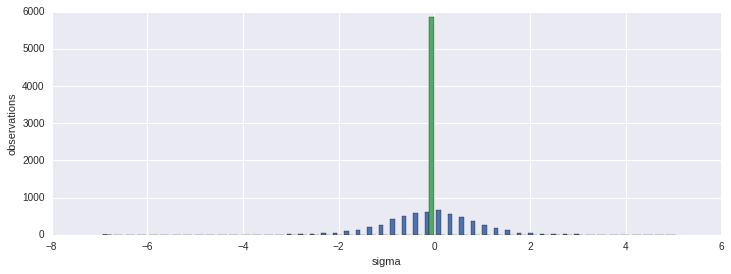

In [357]:
plt.hist([X,ret], bins=50)
plt.xlabel('sigma')
plt.ylabel('observations');

In [349]:
# Sample values from a normal distribution
#X2 = np.random.normal(0, 1, 9000)
both = np.matrix([X,ret])

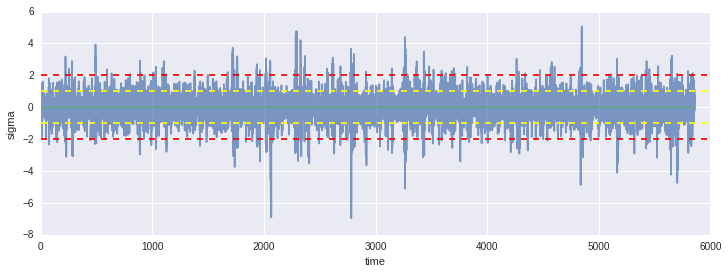

In [353]:
# Plot both the GARCH and normal values
plt.plot(both.T, alpha=.7);
plt.axhline(X.std(), color='yellow', linestyle='--')
plt.axhline(-X.std(), color='yellow', linestyle='--')
plt.axhline(2*X.std(), color='red', linestyle='--')
plt.axhline(-2*X.std(), color='red', linestyle='--')
plt.xlabel('time')
plt.ylabel('sigma');

Testing for ARCH Behavior

In [362]:
X, _ = simulate_GARCH(5961, a0, a1, b1, sigma1)
X = X[100:] # Drop burn in

p = 20

# Drop the first 20 so we have a lag of p's
Y2 = (X**2)[p:]
#X2 = np.ndarray((980, p))
#for i in range(p, 1000):
#    X2[i - p, :] = np.asarray((X**2)[i-p:i])[::-1]
X2=ret[p:]

In [365]:
len(X2)

5841

In [367]:
model = sm.regression.linear_model.OLS(Y2, X2)
model = model.fit()
theta = np.matrix(model.params)
omega = np.matrix(model.cov_HC0)
F = np.asscalar(theta * np.linalg.inv(omega) * theta.T)

print np.asarray(theta.T).shape

(1, 1)


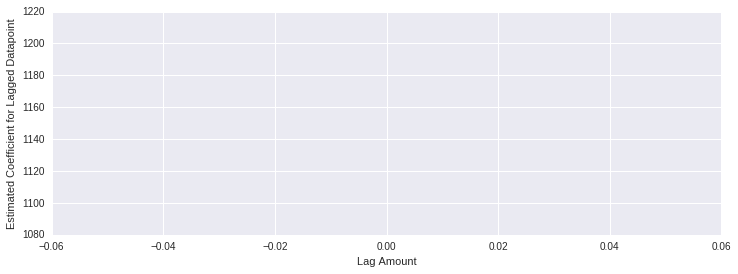

In [372]:
plt.plot(np.asarray(theta.T))
plt.xlabel('Lag Amount')
plt.ylabel('Estimated Coefficient for Lagged Datapoint')

In [373]:
print 'F = ' + str(F)

chi2dist = scipy.stats.chi2(p)
pvalue = 1-chi2dist.cdf(F)
print 'p-value = ' + str(pvalue)

# Finally let's look at the significance of each a_p as measured by the standard deviations away from 0
print theta/np.diag(omega)

F = 0.735320433967
p-value = 0.999999999991
[[ 0.00063984]]


Fitting GARCH(1, 1) with MLE

In [319]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in

In [320]:
# Here's our function to compute the sigmas given the initial guess
def compute_squared_sigmas(X, initial_sigma, theta):
    
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = a0 + a1 * X[t-1]**2 + b1 * sigma2[t-1]
    
    return sigma2

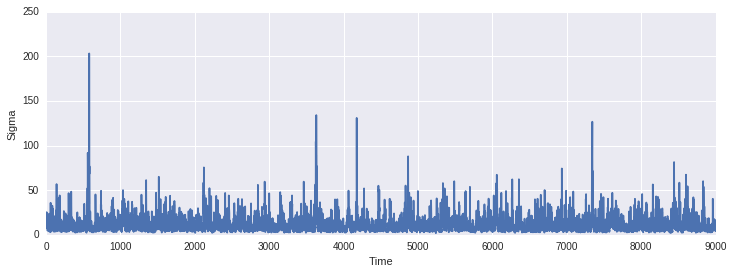

In [322]:
plt.plot(range(len(X)), compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), (1, 0.5, 0.5)))
plt.xlabel('Time')
plt.ylabel('Sigma');

In [323]:
def negative_log_likelihood(X, theta):
    
    T = len(X)
    
    # Estimate initial sigma squared
    initial_sigma = np.sqrt(np.mean(X ** 2))
    
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas(X, initial_sigma, theta)
    
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) for
         t in range(T)]
    )

In [324]:
# Make our objective function by plugging X into our log likelihood function
objective = partial(negative_log_likelihood, X)

# Define the constraints for our minimizer
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

cons = ({'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3})

# Actually do the minimization
result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                        method='SLSQP',
                        constraints = cons)
theta_mle = result.x
print 'theta MLE: ' + str(theta_mle)

theta MLE: [ 0.95615345  0.09680366  0.80394716]


In [325]:
def check_theta_estimate(X, theta_estimate):
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta_estimate))
    epsilon = X / sigma
    print 'Tails table'
    print compare_tails_to_normal(epsilon / np.std(epsilon))
    print ''
    
    _, pvalue, _, _ = jarque_bera(epsilon)
    print 'Jarque-Bera probability normal: ' + str(pvalue)
    
check_theta_estimate(X, theta_mle)

Tails table
[[  1.61000000e-01   2.20000000e-02   2.33333333e-03   0.00000000e+00]
 [  1.58655254e-01   2.27501319e-02   1.34989803e-03   3.16712418e-05]]

Jarque-Bera probability normal: 0.902184803103


In [326]:
# The n-th standardized moment
# skewness is 3, kurtosis is 4
def standardized_moment(x, mu, sigma, n):
    return ((x - mu) ** n) / (sigma ** n)

In [327]:
def gmm_objective(X, W, theta):
    # Compute the residuals for X and theta
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma
    
    # Compute the mean moments
    m1 = np.mean(e)
    m2 = np.mean(e ** 2) - 1
    m3 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 3))
    m4 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 4) - 3)
    
    G = np.matrix([m1, m2, m3, m4]).T
    
    return np.asscalar(G.T * W * G)

def gmm_variance(X, theta):
    # Compute the residuals for X and theta    
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma

    # Compute the squared moments
    m1 = e ** 2
    m2 = (e ** 2 - 1) ** 2
    m3 = standardized_moment(e, np.mean(e), np.std(e), 3) ** 2
    m4 = (standardized_moment(e, np.mean(e), np.std(e), 4) - 3) ** 2
    
    # Compute the covariance matrix g * g'
    T = len(X)
    s = np.ndarray((4, 1))
    for t in range(T):
        G = np.matrix([m1[t], m2[t], m3[t], m4[t]]).T
        s = s + G * G.T
    
    return s / T

In [328]:
# Initialize GMM parameters
W = np.identity(4)
gmm_iterations = 10

# First guess
theta_gmm_estimate = theta_mle

# Perform iterated GMM
for i in range(gmm_iterations):
    # Estimate new theta
    objective = partial(gmm_objective, X, W)
    result = scipy.optimize.minimize(objective, theta_gmm_estimate, constraints=cons)
    theta_gmm_estimate = result.x
    print 'Iteration ' + str(i) + ' theta: ' + str(theta_gmm_estimate)
    
    # Recompute W
    W = np.linalg.inv(gmm_variance(X, theta_gmm_estimate))
    

check_theta_estimate(X, theta_gmm_estimate)

Iteration 0 theta: [ 0.9561606   0.0968213   0.80402849]
Iteration 1 theta: [ 0.95611517  0.09644418  0.80361068]
Iteration 2 theta: [ 0.95611443  0.09643723  0.80360366]
Iteration 3 theta: [ 0.95611443  0.09643723  0.80360366]
Iteration 4 theta: [ 0.95611443  0.09643723  0.80360366]
Iteration 5 theta: [ 0.95611443  0.09643723  0.80360366]
Iteration 6 theta: [ 0.95611443  0.09643723  0.80360366]
Iteration 7 theta: [ 0.95611443  0.09643723  0.80360366]
Iteration 8 theta: [ 0.95611443  0.09643723  0.80360366]
Iteration 9 theta: [ 0.95611443  0.09643723  0.80360366]
Tails table
[[  1.61000000e-01   2.20000000e-02   2.33333333e-03   0.00000000e+00]
 [  1.58655254e-01   2.27501319e-02   1.34989803e-03   3.16712418e-05]]

Jarque-Bera probability normal: 0.901627339174


In [329]:
sigma_hats = np.sqrt(compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), theta_mle))
initial_sigma = sigma_hats[-1]
initial_sigma

3.0530920718126633

In [330]:
a0_estimate = theta_gmm_estimate[0]
a1_estimate = theta_gmm_estimate[1]
b1_estimate = theta_gmm_estimate[2]

X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)

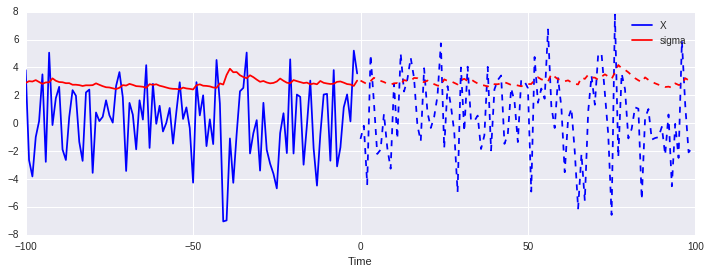

In [331]:
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.plot(range(0, 100), X_forecast, 'b--')
plt.plot(range(0, 100), sigma_forecast, 'r--')
plt.xlabel('Time')
plt.legend(['X', 'sigma']);

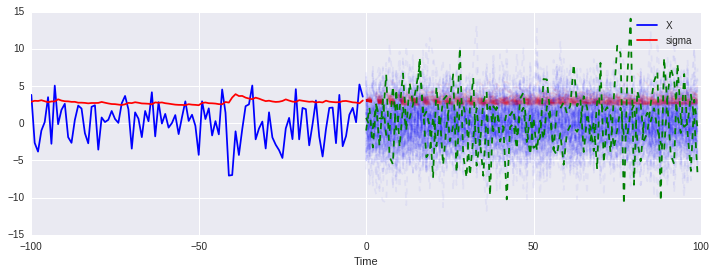

In [332]:
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.xlabel('Time')
plt.legend(['X', 'sigma'])


max_X = [-np.inf]
min_X = [np.inf]
for i in range(100):
    X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)
    if max(X_forecast) > max(max_X):
        max_X = X_forecast
    elif min(X_forecast) < min(max_X):
        min_X = X_forecast
    plt.plot(range(0, 100), X_forecast, 'b--', alpha=0.05)
    plt.plot(range(0, 100), sigma_forecast, 'r--', alpha=0.05)

# Draw the most extreme X values specially
plt.plot(range(0, 100), max_X, 'g--', alpha=1.0)
plt.plot(range(0, 100), min_X, 'g--', alpha=1.0);

In [249]:
df.to_csv('/home/octo/Desktop/PROJECT/DATA/RPy/spy.csv',sep=',')

SVR prediction

In [264]:
import csv
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [251]:
dates = []
prices = []

In [256]:
def get_data(filename):
	with open(filename, 'r') as csvfile:
		csvFileReader = csv.reader(csvfile)
		next(csvFileReader)	# skipping column names
		for row in csvFileReader:
			dates.append(int(row[0].split('-')[0]))
			prices.append(float(row[1]))
	return

In [253]:
def predict_price(dates, prices, x):
	dates = np.reshape(dates,(len(dates), 1)) # converting to matrix of n X 1

	svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1) # defining the support vector regression models
	svr_lin = SVR(kernel= 'linear', C= 1e3)
	svr_poly = SVR(kernel= 'poly', C= 1e3, degree= 2)
	svr_rbf.fit(dates, prices) # fitting the data points in the models
	svr_lin.fit(dates, prices)
	svr_poly.fit(dates, prices)

	plt.scatter(dates, prices, color= 'black', label= 'Data') # plotting the initial datapoints 
	plt.plot(dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') # plotting the line made by the RBF kernel
	plt.plot(dates,svr_lin.predict(dates), color= 'green', label= 'Linear model') # plotting the line made by linear kernel
	plt.plot(dates,svr_poly.predict(dates), color= 'blue', label= 'Polynomial model') # plotting the line made by polynomial kernel
	plt.xlabel('Date')
	plt.ylabel('Price')
	plt.title('Support Vector Regression')
	plt.legend()
	plt.show()

	return svr_rbf.predict(x)[0], svr_lin.predict(x)[0], svr_poly.predict(x)[0]

In [267]:
get_data("//home/octo/Desktop/PROJECT/DATA/RPy/spy.csv")
#print "Dates- ", dates
#print "Prices- ", prices

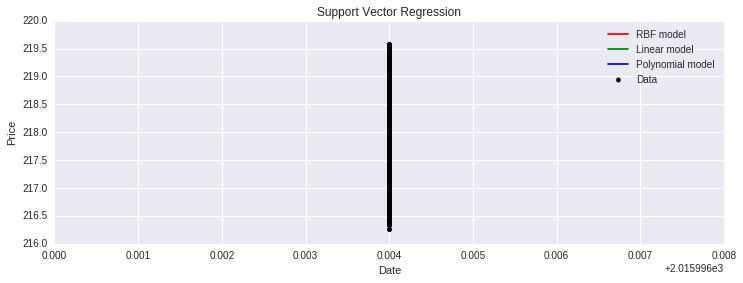


The stock open price for next day:
RBF kernel: $ 218.36
Linear kernel: $ 218.36
Polynomial kernel: $ 218.36


In [269]:
predicted_price = predict_price(dates,prices, 29)  
print "\nThe stock open price for next day:"
print "RBF kernel: $", str(predicted_price[0])
print "Linear kernel: $", str(predicted_price[1])
print "Polynomial kernel: $", str(predicted_price[2])  

In [301]:
df['SVR']=predicted_price[0]

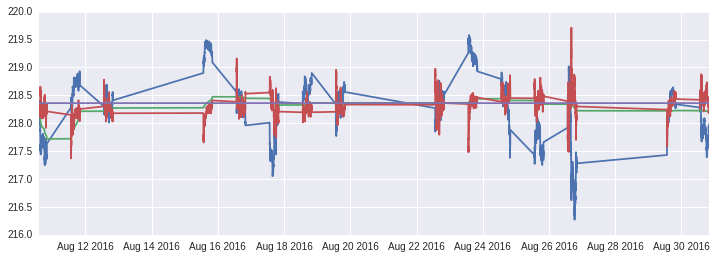

In [305]:
plt.plot(df.CLOSE)
plt.plot(df.vwap)
plt.plot(df.ARIMA)
plt.plot(df.SVR)

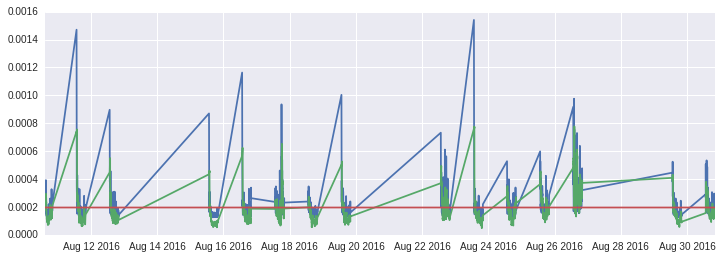

In [306]:
plt.plot(df.GARCH)
plt.plot(df.stdev)
plt.plot(df.bs)